In [1]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [42]:
class LinearRegression:
  
  def __init__(self,X,y, learningRate,epsilon, maxIteration, lamda = 0, stepsize=1,gd = False,sgd = False):
    self.X = X
    self.y = y
    self.learningRate = learningRate
    self.epsilon = epsilon
    self.maxIteration = maxIteration
    self.gd = gd
    self.lamda = lamda
    self.sgd = sgd
    self.stepsize= stepsize


  
  def splitData(self,X,y):
    X_train, X_test, y_train, y_test = train_test_split(self.X,self.y,test_size=0.3,shuffle = True)
    return  X_train, X_test, y_train, y_test

  def addX0(self,X): 
    return np.column_stack([np.ones(X.shape[0]),X])

  def normalizeTrain(self,X):
    mean = np.mean(X, axis = 0)
    std = np.std(X, axis=0)
    X_norm = (X-mean)/std
    X_norm = self.addX0(X_norm)
    return X_norm, mean, std

  def normalizeTest(self,X, mean, std):
    X_norm = (X-mean)/std
    X_norm = self.addX0(X_norm)
    return X_norm


  def rank(self,X):
    v,s,u = np.linalg.svd(X)
    rank = sum([True if abs(i)>0 else False for i in s])
    
    rank = np.linalg.matrix_rank(X)
    return rank
  
  def checkFullrank(self, X):
    print("checkFullrank: x.shape =", X.shape)
    rank = self.rank(X)
    if rank == min(X.shape):
        print('its a full rank')
        self.Fullrank = True
    else: 
        self.Fullrank = False
        print('its not a full rank')


  def checkLowrank(self, X):
    print("checkLowrank: x.shape =", X.shape)
    rank = self.rank(X)
    if X.shape[0] < X.shape[1]:
        self.Lowrank = True
        print('its a low rank')
    else:
        self.Lowrank = False 
        print('its not a low rank')

  def normalEquation(self,X,y):
      self.w = np.linalg.inv(X.T.dot(X)+self.lamda*(np.identity((X.T.dot(X)).shape[0]))).dot(X.T).dot(y)
      if self.lamda >0:
        print('function is being regualirzed')
      return self.w

  def predict(self,X):
      return X.dot(self.w)

  def sse(self,X,y):
      y_hat = self.predict(X)
      return ((y_hat-y)**2).sum()
    
  def costFunction(self,X,y):
      sse = self.sse(X,y)
      return (sse/2)

  def rmse(self,X,y):
    rmse = pow(self.sse(X,y)/(X.shape[0]),0.5) 
    return rmse

  def costDerivative(self,X,y):
      y_hat = self.predict(X)
      return (y_hat-y).dot(X)

  def gradientDescent(self, X,y):
    self.errors = []
    self.errors_sse =[]
    prev_error = float(np.inf)

    for i in tqdm(range(self.maxIteration)):
      grad = self.costDerivative(X,y)
      self.w = self.w - self.learningRate*(grad + self.lamda*self.w)

      current_error = self.costFunction(X,y)
      current_error_rmse = pow(current_error/(X.shape[0]),0.5)
      self.errors.append(current_error_rmse)
      self.errors_sse.append(current_error)
      if abs(current_error_rmse-prev_error) <self.epsilon:
        print("the model stopped learning")
        break
      prev_error = current_error_rmse
    
    if self.lamda >0:
      print('function is being regualirzed')

  
  def sgDescent(self, X, y):
    self.errorssg = []
    self.errorssg_sse=[]
    prev_error = float(np.inf)

    for i in tqdm(range(self.maxIteration)):
        shuffled_indices = np.random.permutation(X.shape[0])
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        for j in range(0, X.shape[0], self.stepsize):
            X_batch = X_shuffled[j:j+self.stepsize]
            y_batch = y_shuffled[j:j+self.stepsize]
            grad = self.costDerivative(X_batch, y_batch)
            self.w = self.w - self.learningRate*(grad + self.lamda*self.w)

        current_error = self.costFunction(X,y)
        current_error_rmse = pow(current_error/(X.shape[0]),0.5)      
        self.errorssg.append(current_error_rmse)
        self.errorssg_sse.append(current_error)
        if abs(current_error_rmse-prev_error) <self.epsilon:
            print("the model stopped learning")
            break
        prev_error = current_error_rmse
    if self.lamda >0:
      print('function is being regualirzed')


  def fit(self):
    self.X_train, self.X_test, self.y_train, self.y_test = self.splitData(self.X,self.y)
    self.X_train, mean, std = self.normalizeTrain(self.X_train)
    self.X_test = self.normalizeTest(self.X_test, mean, std)

    self.checkFullrank(self.X_train)
    self.checkLowrank(self.X_train)

    if self.Fullrank and not self.Lowrank and self.X_train.shape[0] <= 10000 and not self.gd and not self.sgd:
      print('Solving using closed normal solution')
      self.w = self.normalEquation(self.X_train, self.y_train)
      
      print(' ')
      test_rmse = self.rmse(self.X_test,self.y_test)
      print(f'RMSE of Test:{test_rmse}')
      test_sse = self.sse(self.X_test,self.y_test)
      print(f'SSE of Test:{test_sse}')
      
      train_rmse = self.rmse(self.X_train,self.y_train)
      print(f'RMSE of Train:{train_rmse}')
      train_sse = self.sse(self.X_train,self.y_train)
      print(f'SSE of Train:{train_sse}')
      print(' ')

    elif self.Fullrank and not self.Lowrank and self.X_train.shape[0] <= 10000 and not self.gd:
      print('Solving using stochastic gradient descent')
      self.w = np.zeros(self.X_train.shape[1])
      self.sgDescent(self.X_train, self.y_train)
      self.plot_rmse(self.errorssg,Graptitle='RMSE-Plot')
      self.plot_rmse(self.errorssg_sse,Graptitle='SSE-Plot')

      print(' ')
      test_rmse = self.rmse(self.X_test,self.y_test)
      print(f'RMSE of Test:{test_rmse}')
      test_sse = self.sse(self.X_test,self.y_test)
      print(f'SSE of Test:{test_sse}')
      
      train_rmse = self.rmse(self.X_train,self.y_train)
      print(f'RMSE of Train:{train_rmse}')
      train_sse = self.sse(self.X_train,self.y_train)
      print(f'SSE of Train:{train_sse}')
      print(' ')

    
    elif self.Fullrank and not self.Lowrank and self.X_train.shape[0] <= 10000 and not self.sgd:
      print('Solving using gradient descent')
      self.w = np.zeros(self.X_train.shape[1])
      self.gradientDescent(self.X_train, self.y_train)
      self.plot_rmse(self.errors,Graptitle='RMSE-Plot')
      self.plot_rmse(self.errors_sse,Graptitle='SSE-Plot')

      print(' ')
      test_rmse = self.rmse(self.X_test,self.y_test)
      print(f'RMSE of Test:{test_rmse}')
      test_sse = self.sse(self.X_test,self.y_test)
      print(f'SSE of Test:{test_sse}')
      
      train_rmse = self.rmse(self.X_train,self.y_train)
      print(f'RMSE of Train:{train_rmse}')
      train_sse = self.sse(self.X_train,self.y_train)
      print(f'SSE of Train:{train_sse}')
      print(' ')

    else:
      print('Solving using gradient descent')
      self.w = np.zeros(self.X_train.shape[1])
      self.gradientDescent(self.X_train, self.y_train)
      self.plot_rmse(self.errors,Graptitle='RMSE-Plot')
      self.plot_rmse(self.errors_sse,Graptitle='SSE-Plot')

      print(' ')
      test_rmse = self.rmse(self.X_test,self.y_test)
      print(f'RMSE of Test:{test_rmse}')
      test_sse = self.sse(self.X_test,self.y_test)
      print(f'SSE of Test:{test_sse}')
      
      train_rmse = self.rmse(self.X_train,self.y_train)
      print(f'RMSE of Train:{train_rmse}')
      train_sse = self.sse(self.X_train,self.y_train)
      print(f'SSE of Train:{train_sse}')
      print(' ')

    print('Weights of the linear equation:')
    print(self.w)

  
  def plot_rmse(self, error_sequence, Graptitle):
    s = np.array(error_sequence)
    t = np.arange(s.size)

    fig, ax = plt.subplots()
    ax.plot(t,s)

    ax.set(xlabel='iterations', ylabel='errors',title=Graptitle)
    ax.grid()

    plt.legend(bbox_to_anchor=(.05,1), loc=2, shadow=True)
    plt.show()    
    

## DATASET1 : HOUSING

In [43]:
#Load the housing dataset
from google.colab import files
#file = files.upload()  #upload file into google colab session
dfh = pd.read_csv("housing.csv") 
dfh.head()

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [44]:
#splitting the housing data 
X_H = dfh.values[:,0:-1]
y_h = dfh.values[:,-1]

In [45]:
#Dataset - Housing, model- Normalequation, regularization = no
H1 = LinearRegression( X_H, y_h,  learningRate =  0.0004 , gd=False, sgd= False, epsilon=0.005, maxIteration =50000)
H1.fit()

checkFullrank: x.shape = (353, 14)
its a full rank
checkLowrank: x.shape = (353, 14)
its not a low rank
Solving using closed normal solution
 
RMSE of Test:5.3186024763968875
SSE of Test:4299.704909894135
RMSE of Train:4.464028607150812
SSE of Train:7034.425646127669
 
Weights of the linear equation:
[22.11189802 -1.18424695  1.41788128  0.11586286  0.9833197  -1.86265265
  2.23844953 -0.46385343 -3.16520326  2.85606238 -2.05250127 -1.94300472
  0.98538164 -3.22205638]


In [49]:
#Dataset - Housing, model- Normalequation, regularization = yes
H2 = LinearRegression( X_H, y_h, lamda = 10 , learningRate =  0.0004 , gd=False, sgd= False, epsilon=0.005, maxIteration =50000)
H2.fit()

checkFullrank: x.shape = (353, 14)
its a full rank
checkLowrank: x.shape = (353, 14)
its not a low rank
Solving using closed normal solution
function is being regualirzed
 
RMSE of Test:5.749170354156368
SSE of Test:5024.049883688789
RMSE of Train:4.4657779073931945
SSE of Train:7039.939828310881
 
Weights of the linear equation:
[21.83057851 -0.17806656  0.41242741 -0.06213278  0.8662336  -1.08737458
  3.55017405 -0.80558524 -2.15588004  0.86774254 -1.00155171 -1.94209
  1.11578344 -2.41893783]


checkFullrank: x.shape = (353, 14)
its a full rank
checkLowrank: x.shape = (353, 14)
its not a low rank
Solving using gradient descent


  0%|          | 27/50000 [00:00<00:04, 10478.97it/s]


the model stopped learning


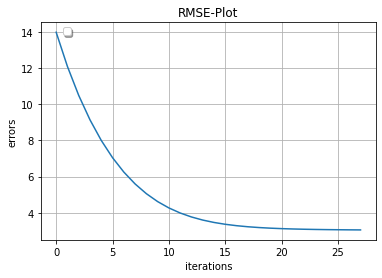

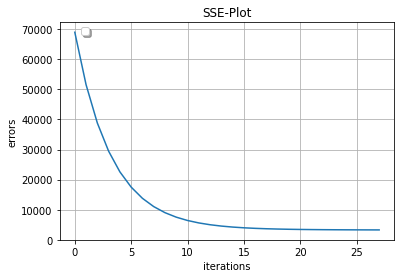

 
RMSE of Test:6.142411403245979
SSE of Test:5734.841112702387
RMSE of Train:4.3109158829887475
SSE of Train:6560.150499822242
 
Weights of the linear equation:
[21.57769669 -0.69115372  0.03135811 -0.19306519  0.75003047 -0.5823562
  3.39439278 -0.26873434 -1.51041312  0.18609874 -0.58164774 -1.91542037
  0.90640147 -2.97169757]


In [50]:
#Dataset - Housing, model- GD, regularization = no
H3 = LinearRegression( X_H, y_h, learningRate =  0.0004 , gd=True, sgd= False, epsilon=0.005, maxIteration =50000)
H3.fit()

checkFullrank: x.shape = (353, 14)
its a full rank
checkLowrank: x.shape = (353, 14)
its not a low rank
Solving using gradient descent


  0%|          | 31/50000 [00:00<00:11, 4423.32it/s]


the model stopped learning
function is being regualirzed


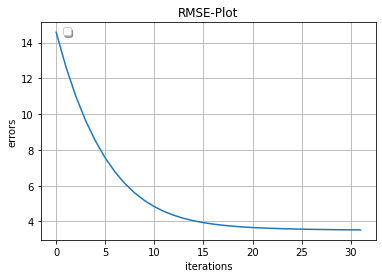

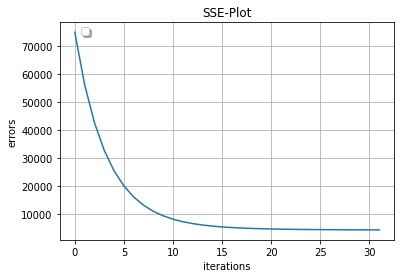

 
RMSE of Test:4.5467638562355965
SSE of Test:3142.3053577842993
RMSE of Train:4.987651207929411
SSE of Train:8781.462593901779
 
Weights of the linear equation:
[21.92618586 -0.58800947  0.54089541 -0.33940302  1.03641935 -0.86594283
  2.83875464 -0.19349149 -1.88459784  0.67455724 -0.52820332 -1.99776435
  0.76592103 -3.27673763]


In [51]:
#Dataset - Housing, model- GD, regularization = yes
H4 = LinearRegression( X_H, y_h, lamda = 10 , learningRate =  0.0004 , gd=True, sgd= False, epsilon=0.005, maxIteration =50000)
H4.fit()

checkFullrank: x.shape = (353, 14)
its a full rank
checkLowrank: x.shape = (353, 14)
its not a low rank
Solving using stochastic gradient descent


  0%|          | 30/50000 [00:00<00:54, 922.04it/s]


the model stopped learning


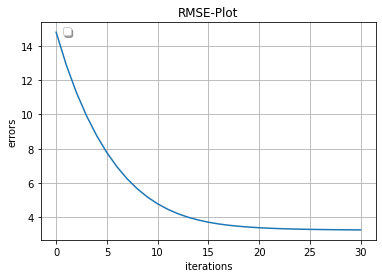

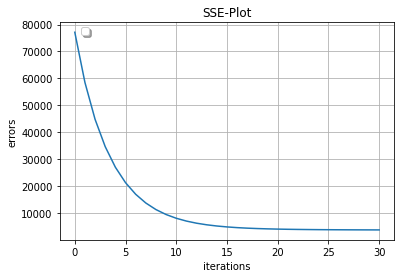

 
RMSE of Test:5.238949514860896
SSE of Test:4171.881986927706
RMSE of Train:4.626626308049065
SSE of Train:7556.201860999097
 
Weights of the linear equation:
[22.44132944 -0.78476045  0.41934501 -0.29334958  0.57443263 -1.16409939
  3.65795993 -0.12735518 -1.85556525  0.82950809 -0.63030905 -1.82661158
  0.6420527  -2.93900949]


In [52]:
#Dataset - Housing, model- SGD, regularization = no
H5 = LinearRegression( X_H, y_h, learningRate =  0.0004 , gd=False, sgd= True, epsilon=0.005, maxIteration =50000,stepsize=5)
H5.fit()

checkFullrank: x.shape = (353, 14)
its a full rank
checkLowrank: x.shape = (353, 14)
its not a low rank
Solving using stochastic gradient descent


  0%|          | 33/50000 [00:00<00:14, 3504.19it/s]


the model stopped learning
function is being regualirzed


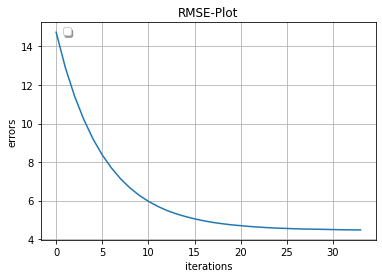

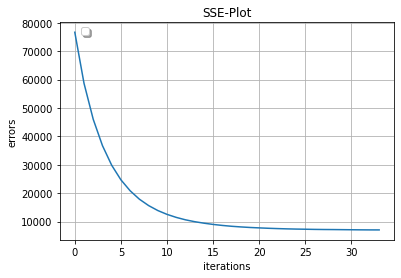

 
RMSE of Test:6.723844731372601
SSE of Test:6871.9333716842775
RMSE of Train:6.3325447016765315
SSE of Train:14155.696206752224
 
Weights of the linear equation:
[18.3808677  -0.45919031  0.48970048 -0.53627389  0.53049381 -0.8032948
  3.16944385 -0.16817707 -1.39597066  0.32502808 -0.59218199 -1.55462729
  0.9069784  -2.43999748]


In [53]:
#Dataset - Housing, model- SGD, regularization = yes
H6 = LinearRegression( X_H, y_h, lamda = 10 , learningRate =  0.0004 , gd=False, sgd= True, epsilon=0.005, maxIteration =50000,stepsize=50)
H6.fit()

## DATASET2 - YATCH

In [54]:
#Load the housing dataset
from google.colab import files
#file = files.upload()  #upload file into google colab session
dfy = pd.read_csv("yachtData.csv") 
dfy.head()

#splitting the housing data 
X_Y = dfy.values[:,0:-1]
y_y = dfy.values[:,-1]

In [55]:
#Dataset - Yatch, model- Normalequation, regularization = no
Y1 = LinearRegression( X_Y, y_y,  learningRate =  0.001 , gd=False, sgd= False, epsilon=0.001, maxIteration =50000)
Y1.fit()

checkFullrank: x.shape = (214, 7)
its a full rank
checkLowrank: x.shape = (214, 7)
its not a low rank
Solving using closed normal solution
 
RMSE of Test:9.842577355128858
SSE of Test:9009.49859622767
RMSE of Train:8.481476063478679
SSE of Train:15394.183350087422
 
Weights of the linear equation:
[10.41425234 -0.5985184   0.18974684  2.00014187 -1.59389489 -1.72621005
 12.03085856]


In [56]:
#Dataset - Yatch, model- Normalequ, regularization = yes
Y2 = LinearRegression( X_H, y_h, lamda = 10 ,learningRate =  0.001 , gd=False, sgd= False, epsilon=0.001, maxIteration =50000)
Y2.fit()

checkFullrank: x.shape = (353, 14)
its a full rank
checkLowrank: x.shape = (353, 14)
its not a low rank
Solving using closed normal solution
function is being regualirzed
 
RMSE of Test:5.219431996309396
SSE of Test:4140.855495342939
RMSE of Train:4.570615741132427
SSE of Train:7374.356473339894
 
Weights of the linear equation:
[21.84545455 -0.93780283  0.80327189  0.07520533  0.55419816 -1.59185507
  3.36773324 -0.51656983 -2.7402907   1.70814478 -1.33183766 -1.93086712
  0.79099824 -3.02501703]


checkFullrank: x.shape = (214, 7)
its a full rank
checkLowrank: x.shape = (214, 7)
its not a low rank
Solving using gradient descent


  0%|          | 18/50000 [00:00<00:02, 21533.79it/s]


the model stopped learning


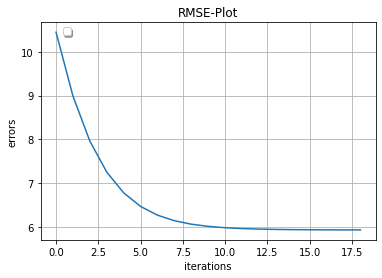

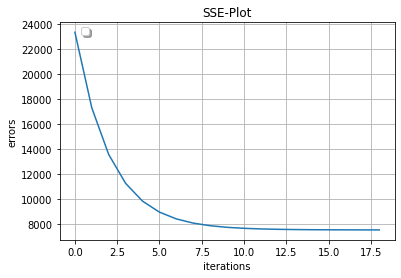

 
RMSE of Test:9.931499933562304
SSE of Test:9173.02625652237
RMSE of Train:8.398213628022326
SSE of Train:15093.418318366583
 
Weights of the linear equation:
[ 9.83428936e+00  1.24896841e-01 -1.14965209e-02  2.39572158e-01
 -3.88848854e-01  6.37981412e-02  1.17119954e+01]


In [57]:
#Dataset - Yatch, model- GD, regularization = no
Y3 = LinearRegression( X_Y, y_y,  learningRate =  0.001 , gd=True, sgd= False, epsilon=0.001, maxIteration =50000)
Y3.fit()

checkFullrank: x.shape = (214, 7)
its a full rank
checkLowrank: x.shape = (214, 7)
its not a low rank
Solving using gradient descent


  0%|          | 22/50000 [00:00<00:04, 11595.21it/s]


the model stopped learning
function is being regualirzed


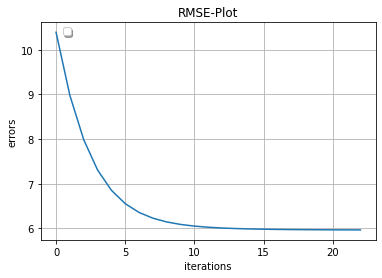

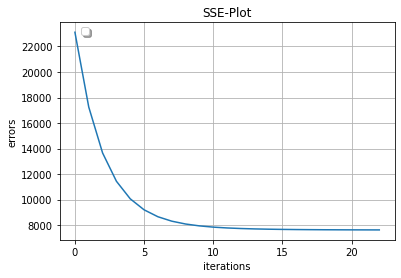

 
RMSE of Test:10.11293426694345
SSE of Test:9511.243872339272
RMSE of Train:8.43995758231416
SSE of Train:15243.837174130127
 
Weights of the linear equation:
[ 9.46460103  0.13447418 -0.61550279  0.20458473  0.20401235 -0.64552679
 11.1046017 ]


In [58]:
#Dataset - Yatch, model- GD, regularization = Yes
Y4 = LinearRegression( X_Y, y_y,  lamda=10, learningRate =  0.001 , gd=True, sgd= False, epsilon=0.001, maxIteration =50000)
Y4.fit()

checkFullrank: x.shape = (214, 7)
its a full rank
checkLowrank: x.shape = (214, 7)
its not a low rank
Solving using stochastic gradient descent


  0%|          | 19/50000 [00:00<00:18, 2743.73it/s]


the model stopped learning


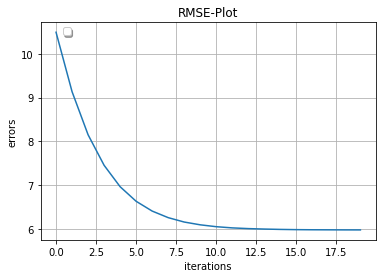

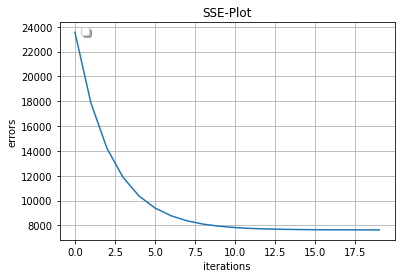

 
RMSE of Test:9.899704488260475
SSE of Test:9114.38585280427
RMSE of Train:8.448412392381298
SSE of Train:15274.393797672761
 
Weights of the linear equation:
[ 9.78409366  0.4762128  -0.0856055   0.0451863  -0.034531    0.13787588
 11.3727356 ]


In [59]:
#Dataset - Yatch, model- SGD, regularization = no
Y5 = LinearRegression( X_Y, y_y, learningRate =  0.001 , gd=False, sgd= True, epsilon=0.001, maxIteration =50000,stepsize=50)
Y5.fit()

checkFullrank: x.shape = (214, 7)
its a full rank
checkLowrank: x.shape = (214, 7)
its not a low rank
Solving using stochastic gradient descent


  0%|          | 27/50000 [00:00<00:06, 7329.85it/s]


the model stopped learning
function is being regualirzed


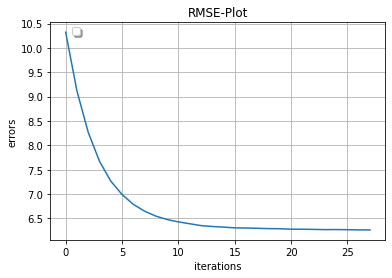

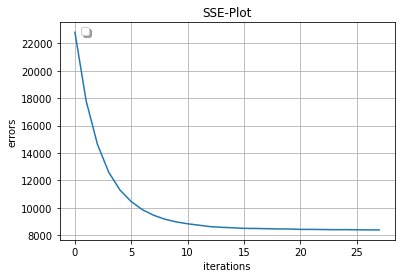

 
RMSE of Test:11.438071233553226
SSE of Test:12167.141039576916
RMSE of Train:8.85748013233279
SSE of Train:16789.360219059403
 
Weights of the linear equation:
[ 7.86468897  0.26667979 -0.18593509  0.07542963  0.18715781  0.05159071
  9.04742343]


In [60]:
#Dataset - Yatch, model- SGD, regularization = Yes
Y6 = LinearRegression( X_Y, y_y,  lamda=10, learningRate =  0.001 , gd=False, sgd= True, epsilon=0.001, maxIteration =50000,stepsize=50)
Y6.fit()

# DATASET3: ConcreteData

In [61]:
#Load the housing dataset
from google.colab import files
#file = files.upload()  #upload file into google colab session
dfc = pd.read_csv("concreteData.csv") 
dfc.head()

#splitting the housing data 
X_C = dfc.values[:,0:-1]
y_c = dfc.values[:,-1]

In [62]:
#Dataset - Concrete, model- Normalequation, regularization = no
C1 = LinearRegression( X_C, y_c,  learningRate =  0.0007 , gd=False, sgd= False, epsilon=0.0001, maxIteration =50000)
C1.fit()

checkFullrank: x.shape = (720, 9)
its a full rank
checkLowrank: x.shape = (720, 9)
its not a low rank
Solving using closed normal solution
 
RMSE of Test:10.412537028786033
SSE of Test:33502.06655913465
RMSE of Train:10.30689615846677
SSE of Train:76487.11806342029
 
Weights of the linear equation:
[35.78872222 12.05182527  8.33708762  5.03597037 -3.66460158  1.68115588
  1.04571362  1.26562728  7.5585661 ]


In [63]:
#Dataset - Concrete, model- Normalequation, regularization = yes
C2 = LinearRegression( X_C, y_c, lamda = 10, learningRate =  0.0007 , gd=False, sgd= False, epsilon=0.0001, maxIteration =50000)
C2.fit()

checkFullrank: x.shape = (720, 9)
its a full rank
checkLowrank: x.shape = (720, 9)
its not a low rank
Solving using closed normal solution
function is being regualirzed
 
RMSE of Test:10.641124365054154
SSE of Test:34989.160075537686
RMSE of Train:10.274604747498891
SSE of Train:76008.60195647526
 
Weights of the linear equation:
[ 3.52540959e+01  1.08987692e+01  7.29348639e+00  4.06667168e+00
 -4.45901397e+00  1.27889910e+00 -1.50425929e-02  1.54056336e-01
  6.90165250e+00]


checkFullrank: x.shape = (720, 9)
its a full rank
checkLowrank: x.shape = (720, 9)
its not a low rank
Solving using gradient descent


  0%|          | 122/50000 [00:00<00:02, 17684.03it/s]


the model stopped learning


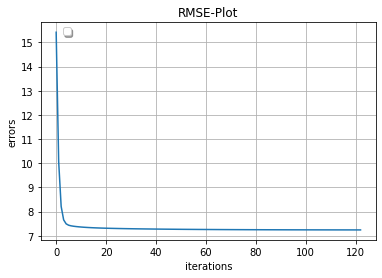

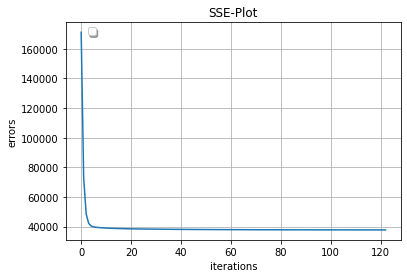

 
RMSE of Test:10.620966119685418
SSE of Test:34856.7206864912
RMSE of Train:10.241688162502651
SSE of Train:75522.3670209218
 
Weights of the linear equation:
[36.49533333 11.11251548  8.08396422  4.57835947 -3.812089    2.42286267
  0.78669542  0.34057573  7.25122485]


In [64]:
#Dataset - Concrete, model- GD, regularization = no
C3 = LinearRegression( X_C, y_c,  learningRate =  0.0007 , gd=True, sgd= False, epsilon=0.0001, maxIteration =50000)
C3.fit()

checkFullrank: x.shape = (720, 9)
its a full rank
checkLowrank: x.shape = (720, 9)
its not a low rank
Solving using gradient descent


  0%|          | 129/50000 [00:00<00:03, 16122.32it/s]


the model stopped learning
function is being regualirzed


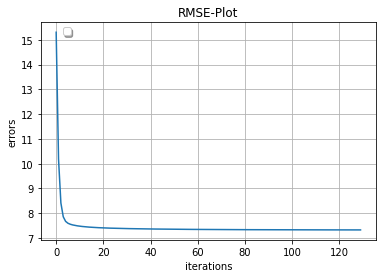

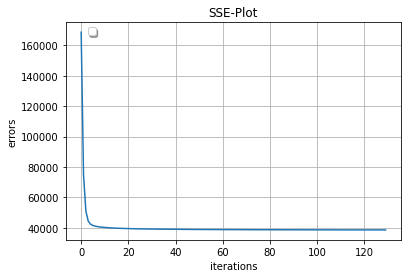

 
RMSE of Test:10.400441590216797
SSE of Test:33424.278248897
RMSE of Train:10.364230016225232
SSE of Train:77340.42995704133
 
Weights of the linear equation:
[ 3.54212466e+01  1.05769624e+01  7.40378512e+00  4.42794896e+00
 -4.57634929e+00  1.72472807e+00  4.01831692e-01  2.63820236e-02
  7.12919751e+00]


In [65]:
#Dataset - Concrete, model- GD, regularization = Yes
C4 = LinearRegression( X_C, y_c, lamda =10, learningRate =  0.0007 , gd=True, sgd= False, epsilon=0.0001, maxIteration =50000)
C4.fit()

checkFullrank: x.shape = (720, 9)
its a full rank
checkLowrank: x.shape = (720, 9)
its not a low rank
Solving using stochastic gradient descent


  0%|          | 42/50000 [00:00<00:36, 1358.15it/s]


the model stopped learning


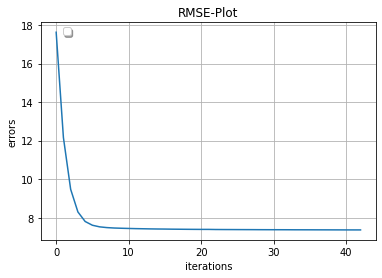

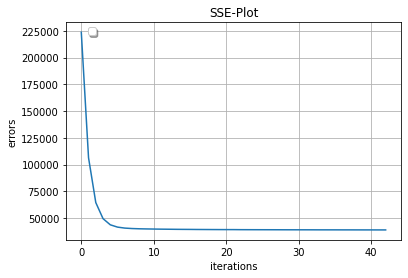

 
RMSE of Test:10.532570632675435
SSE of Test:34278.928636879784
RMSE of Train:10.416826728844221
SSE of Train:78127.40095110964
 
Weights of the linear equation:
[35.70866153  8.57234152  5.27748558  3.01409074 -5.70934665  1.59839072
 -1.19722021 -1.5901338   7.42401697]


In [66]:
#Dataset - Concrete, model- SGD, regularization = no
C5 = LinearRegression( X_C, y_c,  learningRate =  0.0007 , gd=False, sgd= True, epsilon=0.0001, maxIteration =50000,stepsize=50)
C5.fit()

checkFullrank: x.shape = (720, 9)
its a full rank
checkLowrank: x.shape = (720, 9)
its not a low rank
Solving using stochastic gradient descent


  0%|          | 118/50000 [00:00<00:15, 3120.27it/s]


the model stopped learning
function is being regualirzed


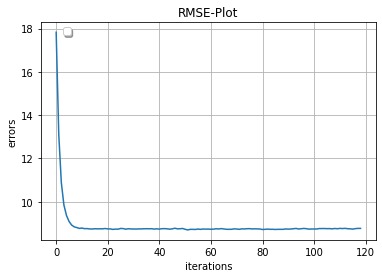

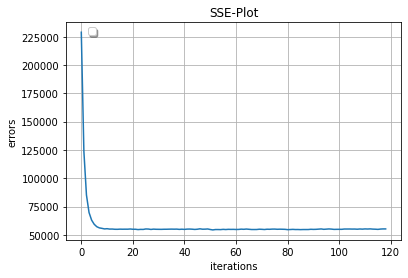

 
RMSE of Test:13.221262085603964
SSE of Test:54013.74728109472
RMSE of Train:12.396658179916171
SSE of Train:110647.53650137142
 
Weights of the linear equation:
[28.8666892   5.84486723  3.14429771  0.44352061 -4.17665104  2.95085651
 -1.35075658 -1.9281262   5.72770904]


In [67]:
#Dataset - Concrete, model- SGD, regularization = Yes
C6 = LinearRegression( X_C, y_c, lamda=10,  learningRate =  0.0007 , gd=False, sgd= True, epsilon=0.0001, maxIteration =50000,stepsize=50)
C6.fit()

#Observations:

*  **Effects of the learning rate**- If we decrease the learning rate, it is taking more iterations to reach the cutoff. While we increase the learnign rate, it's taking lesser time and at one point its jumping out ang giving a very high error and the chances of reaching the global minimum was less.
*  **regularization parameters** - Changing the regualisation parameter is optimising the coeeficients of the line equation (wi), if we increase the regularisation coefficient (lamda), the weights of the linear equations are reducing.


# Checking the impact of learning rate with Concrete data set on SGD

checkFullrank: x.shape = (720, 9)
its a full rank
checkLowrank: x.shape = (720, 9)
its not a low rank
Solving using stochastic gradient descent


 80%|███████▉  | 39788/50000 [00:10<00:02, 3715.76it/s]


the model stopped learning
function is being regualirzed


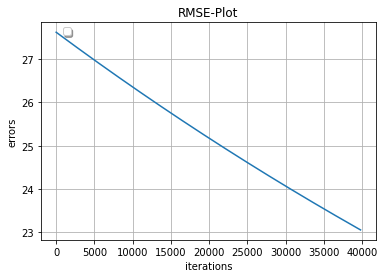

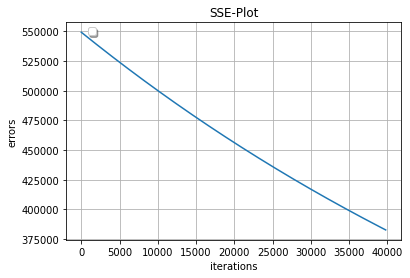

[ 6.30025197  1.40381436  0.42922265 -0.28232662 -0.85104722  1.04563544
 -0.50185291 -0.44092599  1.00777611]


In [ ]:
#Dataset - Concrete, model- SGD, regularization = Yes
#here we have taken a really low learning rate, it took 80% of the max iterations to reach the minimun
C6 = LinearRegression( X_C, y_c, lamda=10,  learningRate =  0.000000007 , gd=False, sgd= True, epsilon=0.0001, maxIteration =50000,stepsize=50)
C6.fit()

checkFullrank: x.shape = (720, 9)
its a full rank
checkLowrank: x.shape = (720, 9)
its not a low rank
Solving using stochastic gradient descent


  2%|▏         | 827/50000 [00:00<00:20, 2396.40it/s]


the model stopped learning
function is being regualirzed


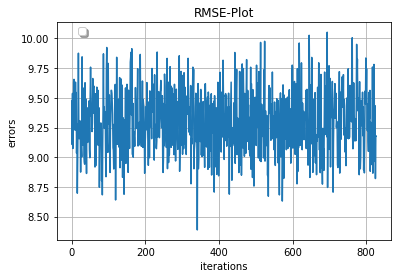

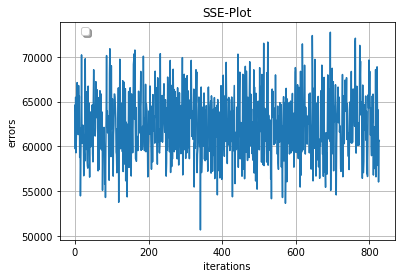

[28.99812884  6.06182301  1.78771541  1.54019247 -4.73589745  3.61594768
 -0.95262159 -1.11180303  6.13067567]


In [ ]:
#Dataset - Concrete, model- SGD, regularization = Yes
#here we have taken a high learning rate, it came to min very quickly, it could be a local minimum
C6 = LinearRegression( X_C, y_c, lamda=10,  learningRate =  0.007 , gd=False, sgd= True, epsilon=0.0001, maxIteration =50000,stepsize=50)
C6.fit()

checkFullrank: x.shape = (720, 9)
its a full rank
checkLowrank: x.shape = (720, 9)
its not a low rank
Solving using stochastic gradient descent


  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
<ipython-input-77-6d8dcea6cc46>:76: RuntimeWarning: overflow encountered in square
  return ((y_hat-y)**2).sum()
<ipython-input-77-6d8dcea6cc46>:128: RuntimeWarning: invalid value encountered in double_scalars
  if abs(current_error_rmse-prev_error) <self.epsilon:
<ipython-input-77-6d8dcea6cc46>:122: RuntimeWarning: overflow encountered in add
  self.w = self.w - self.learningRate*(grad + self.lamda*self.w)
100%|██████████| 50000/50000 [00:13<00:00, 3792.08it/s]


function is being regualirzed


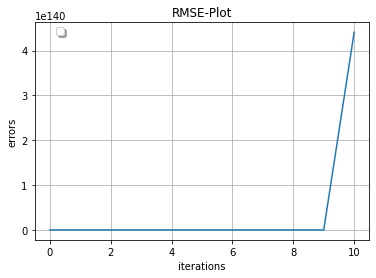

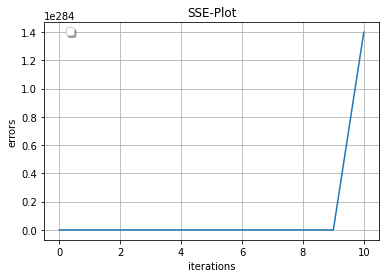

[nan nan nan nan nan nan nan nan nan]


In [ ]:
#Dataset - Concrete, model- SGD, regularization = Yes
#here we have taken a very high learning rate and it bounced off to infinity
C6 = LinearRegression( X_C, y_c, lamda=10,  learningRate =  0.07 , gd=False, sgd= True, epsilon=0.0001, maxIteration =50000,stepsize=50)
C6.fit()